# Gibbs-Duhem consistency and molar propertie tests

In [3]:
import numpy as np
from epcsaftpy import component, pcsaft 
import matplotlib.pyplot as plt

**Test** <br> 

The coded equation of state was tested to pass the following molar partial property test and Gibbs-Duhem consistency:

$$\ln \phi - \sum_{i=1}^c x_i \ln \hat{\phi}_i = 0$$

$$ \dfrac{d \ln \phi}{d P}  - \dfrac{Z - 1}{P} = 0$$

$$ \sum_{i=1}^c x_i d \ln \hat{\phi}_i = 0$$

Here, $\phi$ is the fugacity coefficient of the mixture,  $x_i$ and $\hat{\phi}_i$ is the mole fraction and fugacity coefficient of component $i$, $P$  refers to pressure and $Z$ to the compressibility factor.

In [5]:
Na = 6.022142e23    # [mol-1] Avogadro's Number
def test(saft, T, P, state = 'L', j = 0):
    temp_aux = saft.temperature_aux(T)
    beta = temp_aux[0]
    RT = Na/beta

    x1 = np.linspace(0, 1, 100)
    x = np.array([x1, 1 - x1]).T

    dP, dGD, dfug = np.zeros_like(x1), np.zeros_like(x1), np.zeros_like(x1)

    h = np.finfo(1.0).eps
    eye_h = 1j * np.eye(2) * h
    v, Xass = None, None
    for i in range(100):
        fugef, v, Xass = saft.logfugef_aux(x[i], temp_aux, P, state, v0 = v, Xass0 = Xass)
        Z = P * v / RT
        fug, v, Xass = saft.logfugmix_aux(x[i], temp_aux, P, state, v0 = v, Xass0 = Xass)
        dfug[i] = fug - np.dot(fugef, x[i])   # Eq. 1
        
        fug_mh, _, _ = saft.logfugef_aux(x[i], temp_aux, P + 1j * h, state)
        dfugdP = fug_mh.imag/h
        dP[i] =  np.dot(x[i], dfugdP) - (Z - 1) / P # Eq. 2
        

        fug_mh, _, _ = saft.logfugef_aux(x[i] + eye_h[j], temp_aux, P, state)
        dfugdX = fug_mh.imag/h
        dGD[i] = np.dot(x[i], dfugdX)

    font = {'weight' : 'normal',
            'size'   : 16}
    plt.rc('font', **font)


    fig = plt.figure(figsize = (14,3))
    fig.subplots_adjust(wspace = 0.3)
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    ax1.plot(x1, dfug, '.', c = "#FC7725")
    ax1.set_ylabel(r'$d\ln\phi$')
    ax1.set_xlabel('$x_{1}$ / mol $\cdot$ mol$^{-1}$')
    start, end = ax1.get_ylim()
    ax1.axis([0, 1, start, end])
    ax2.plot(x1, dP, '.', c = "#49C60A")
    ax2.set_ylabel(r'$d\ln\phi/dP$')
    ax2.set_xlabel('$x_{1}$ / mol $\cdot$ mol$^{-1}$')
    start, end = ax2.get_ylim()
    ax2.axis([0, 1, start, end])
    ax3.plot(x1, dGD, '.', c = "#FC7725")
    ax3.set_ylabel(r'$dGD$')
    ax3.set_xlabel('$x_{1}$ / mol $\cdot$ mol$^{-1}$')
    start, end = ax3.get_ylim()
    ax3.axis([0, 1, start, end])
    plt.show()

## Mixture 1: Associative + Associative

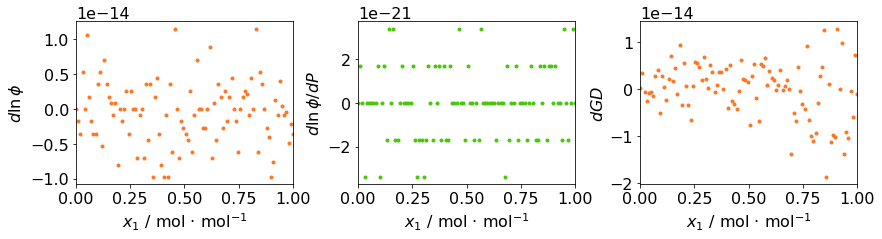

In [7]:
Water = component('Water', ms = 1.2046817736, sigma = [2.7927, 10.11, -0.01775, -1.417, -0.01146], eps = 353.9449,
                 kappaAB = 0.045090, eAB = 2425.6714, sites = [0, 1, 1], Mw = 18.01528, cii = 1.0624e-20)
Ment = component('Menthol', ms = 4.152, sigma = 3.903, eps = 262.40,
                 kappaAB = 0.0996, eAB = 1785.6 , sites = [0, 1, 1], Mw =  156.27 )
mix = Water + Ment  
mix.set_kijsaft(i = 0, j = 1, kij0 = -0.001, kij1 = 0.00009)
saft = pcsaft(mix)

T = 298.15
P = 1e5
test(saft, T, P, state = 'L', j = 0)

## Mixture 2: Polar + Polar

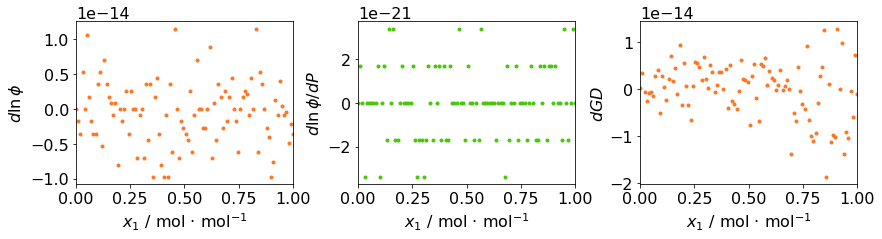

In [8]:
R134a = component('R134a', ms = 2.154, sigma = 3.527, eps=  157.227, 
                   mupol = 2.058, xpol = 0.50, Mw = 102.031, viscosity_parameters = [-1.0273633, -1.75196, -0.17433, -0.02626])
R1234ze = component('R1234ze(E)', ms = 2.811, sigma = 3.369, eps=  176.935, 
                   mupol = 1.440, xpol = 1/3., Mw = 114.042, viscosity_parameters = [-1.1145601, -2.15343, -0.12539, 0.005379])
mix = R134a + R1234ze
eos = pcsaft(mix)

T = 298.15
P = 1e5
test(saft, T, P, state = 'L', j = 0)